In [175]:
!pip install textblob
!pip  install tdqm
!pip streamlit

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1333 sha256=9cf53ede06fe23205af729cef7957f5cc6a2d33edae984032d8566234fa4040c
  Stored in directory: c:\users\nouna\appdata\local\pip\cache\wheels\c8\c7\30\e5935be2cfa6883be72462333edc414d8928f3c78eaabec38a
Successfully built tdqm


In [119]:
# Dataframe
import numpy as np
import pandas as pd

# Utilities
import re
import random
from tqdm import tqdm

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# NLP 
import nltk
from nltk.corpus import stopwords # Stopwords
from nltk.stem.snowball import SnowballStemmer # Stemmisation
from nltk.stem import WordNetLemmatizer # Lemmatisation
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk import classify
from textblob.classifiers import NaiveBayesClassifier

# TfIDf 
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# Optimization
from sklearn.model_selection import GridSearchCV

# Model Saving
import pickle
# Metrics
from sklearn.metrics import f1_score,recall_score,precision_score,mean_squared_error,accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

# 1. Acquisition et pretraitement des donnees <a id="part1"></a>

### 1.1 Chargement des donnees

In [2]:
# chargement des donnees
datas = pd.read_csv("datas/dataset.csv")

In [3]:
datas.head(100)

,tweet_id,polarity,text
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...
1,263791921753882624,neutral,Some areas of New England could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...
...,...,...,...
95,263909653820362752,neutral,If you do another season of Big Brother please...
96,264245061900959744,positive,@h0tlikepayne: It\u2019s #confirmed that you c...
97,263839149767917568,neutral,i said it b4 dat gucci been promoting his mixt...
98,264231323089125376,positive,Busy day tomorrow\u002c staging at bliss inste...


In [4]:
datas.shape

(50132, 3)

### 1.2 Comprehension des donnees

In [5]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50132 entries, 0 to 50131
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  50132 non-null  int64 
 1   polarity  50132 non-null  object
 2   text      50132 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [6]:
# Nombre de doublons
datas.duplicated().sum()

665

In [7]:
# Supression des doublons
datas.drop_duplicates(inplace = True)
datas.shape

(49467, 3)

In [8]:
# On reorganise les indexs
datas = datas.reset_index(drop = True)

In [9]:
# On verifie
datas.duplicated().sum()

0

In [10]:
# Les valeurs manquantes
datas.isna().sum()

tweet_id    0
polarity    0
text        0
dtype: int64

In [11]:
# Pour decrire les données comme variables qualitatives ou catégorielles
datas.astype('object').describe().transpose()

,count,unique,top,freq
tweet_id,49467,49368,625865025585053697,2
polarity,49467,3,neutral,22182
text,49467,49366,Perseverance is failing 19 times and succeedin...,6


In [12]:
# Quelques proportions
datas.polarity.value_counts()

polarity
neutral     22182
positive    19572
negative     7713
Name: count, dtype: int64

In [13]:
datas

,tweet_id,polarity,text
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...
1,263791921753882624,neutral,Some areas of New England could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...
...,...,...,...
49462,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...
49463,639979760735662080,neutral,everyone who sat around me at metlife was so a...
49464,640196838260363269,neutral,what giants or niners fans would wanna go to t...
49465,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs...


## 1.3 Pretraitement des donnees

### 1.1 Normalisation des donnees

In [14]:
# Afficher tout le text sans tronqué pour bien voir le contenu des tweets
print(pd.get_option('display.max_colwidth'))
pd.set_option('display.max_colwidth', None)
datas.head()

50


,tweet_id,polarity,text
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s and debates. Gulp. Debates...
1,263791921753882624,neutral,Some areas of New England could see the first flakes of the season Tuesday.
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.
3,264041328420204544,neutral,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that\u2019s all he could throw to sunday night.


In [15]:
# Fonction de normalisation des donnees
def text_preprocessing(message):
    
    message = re.sub('((www\.[^\s]+) | (https?://[^\s]+))','URL',message)
    message = re.sub('@["\s)+]','USER',message)
    message = message.lower().replace("ë","e")
    # Removing html tags
#     message = remove_tags(message)
#     # Single character removal
#     message = re.sub(r"s+[a-zA-Z]s+", ' ', message)
#     # Removing multiple spaces
#     message = re.sub(r's+', ' ', message)
    
    pattern = r"[^a-zA\s,']"
    message = re.sub(pattern,' ', message) # selectionne les caracteres speciaux et les remplace par un espace
    message = re.sub(" +",' ', message)
    return message.strip()

In [16]:
datas['text_cleaned'] = datas.text.apply(text_preprocessing).tolist()

In [17]:
datas.head(10)

,tweet_id,polarity,text,text_cleaned
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s and debates. Gulp. Debates...,won the match getin plus u c tomorrow is a very busy day u c with awareness day u s and debates gulp debates
1,263791921753882624,neutral,Some areas of New England could see the first flakes of the season Tuesday.,some areas of new england could see the first flakes of the season tuesday
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.,francesco con nd worst qb definitely tony romo the man who likes to share the ball with everyone including the other team
3,264041328420204544,neutral,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs,thailand washington us president barack obama vowed wednesday as he visited storm ravaged new jersey shore to url
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that\u2019s all he could throw to sunday night.,did y u all hear what tony romo dressed up as for halloween a giants quaterback cause that u s all he could throw to sunday night
5,263722278712393728,positive,Tim Tebow may be availible ! Wow Jerry \u002c what the heck you waiting for ! http://t.co/a7z9FBL4,tim tebow may be availible wow jerry u c what the heck you waiting for url
6,262936443171778560,positive,@mariakaykay aga tayo tomorrow ah. :) Good night\u002c Ces. Love you! >:D<,mariakaykay aga tayo tomorrow ah good night u c ces love you d
7,260486470828171265,neutral,Tina Fey & Amy Poehler are hosting the Golden Globe awards on January 13. What do you think?,tina fey amy poehler are hosting the golden globe awards on january what do you think
8,262968617233162240,positive,Lunch from my new Lil spot ...THE COTTON BOWL ....pretty good#1st#time#will be going back# http://t.co/Dbbj8xLZ,lunch from my new lil spot the cotton bowl pretty good st time will be going back url
9,263790847424880641,positive,SNC Halloween Pr. Pumped. Let\u2019s work it for Sunday....Packers vs....who knows or caresn. #SNC #cheerpracticeonhalloween,snc halloween pr pumped let u s work it for sunday packers vs who knows or caresn snc cheerpracticeonhalloween


## 1.4 Supression des Stop words

In [18]:
# Stop words en anglais
stop_words = stopwords.words('english')


In [19]:
# Custom stopwords
my_file = open("stopwords.txt", "r", encoding="utf-8")
STOPWORDS = my_file.readlines()
STOPWORDS = [i.replace('\n', '') for i in STOPWORDS]
STOPWORDS = STOPWORDS + stop_words

In [20]:
# Custom stopwords list
stopword = set(STOPWORDS)

In [21]:
datas.text_cleaned = datas.text_cleaned.apply(lambda message: ' '.join([mot for mot in message.split() if mot not in (stopword)]))

In [22]:
datas

,tweet_id,polarity,text,text_cleaned
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s and debates. Gulp. Debates...,match getin plus busy awareness debates gulp debates
1,263791921753882624,neutral,Some areas of New England could see the first flakes of the season Tuesday.,england flakes season
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.,francesco con worst qb definitely tony romo likes share ball including
3,264041328420204544,neutral,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs,thailand washington president barack obama vowed visited storm ravaged jersey shore
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that\u2019s all he could throw to sunday night.,hear tony romo dressed halloween giants quaterback cause throw
...,...,...,...,...
49462,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLife in December is a task just hope hes up for it.,racalto sk ok punting metlife task hope hes
49463,639979760735662080,neutral,everyone who sat around me at metlife was so annoying but i didnt let it ruin such an amazing night,metlife annoying didnt ruin amazing
49464,640196838260363269,neutral,what giants or niners fans would wanna go to the sunday night game at Metlife?,giants niners fans wanna metlife
49465,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs Peru at MetLife?,ticket colombia vs peru metlife


## 1.5 Analyse exploratoire

### 1.5.1 Analyse univariee

<Axes: xlabel='polarity', ylabel='count'>

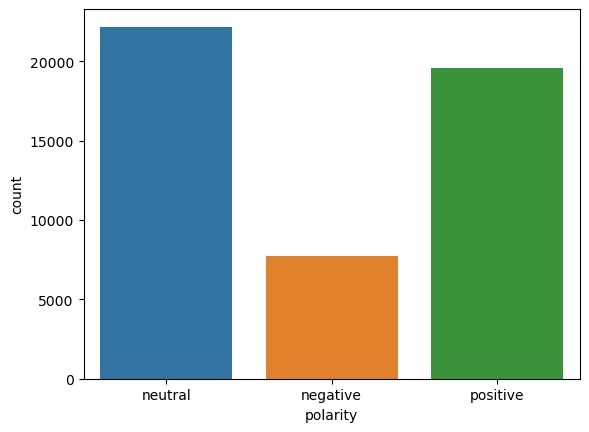

In [23]:
sns.countplot(x = datas.polarity, data = datas)

> On n'a pas les memes proportions pour les differentes classes se qui peut considerablement affecter la performance de notre modele

In [24]:
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=stopword, 
                          background_color='white').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

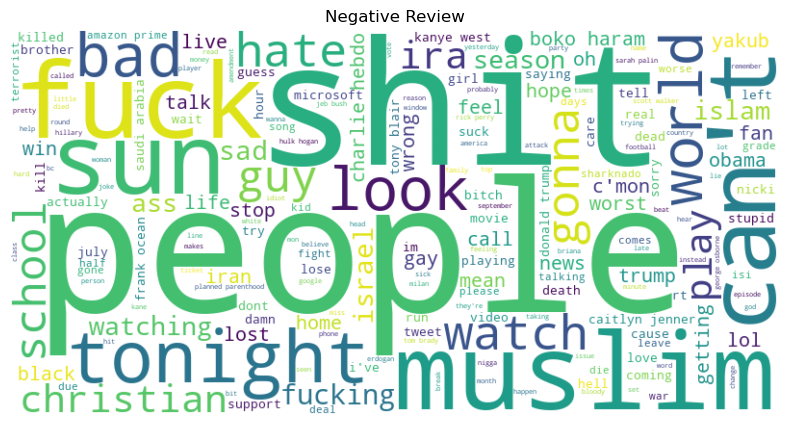

In [25]:
# Nuage de mots des tweets positifs
negative = datas[datas['polarity']=='negative']['text_cleaned']
negative
generate_wordcloud(negative,'Negative Review')

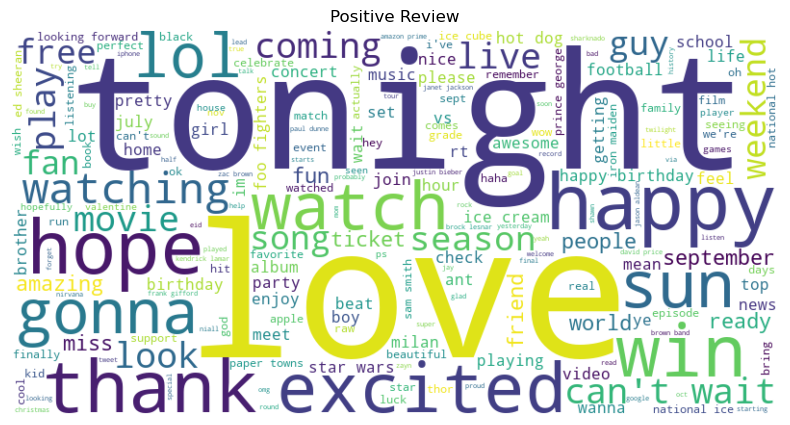

In [26]:
# Nuage de mots des tweets positifs
positive = datas[datas['polarity']=='positive']['text_cleaned']
positive
generate_wordcloud(positive,'Positive Review')

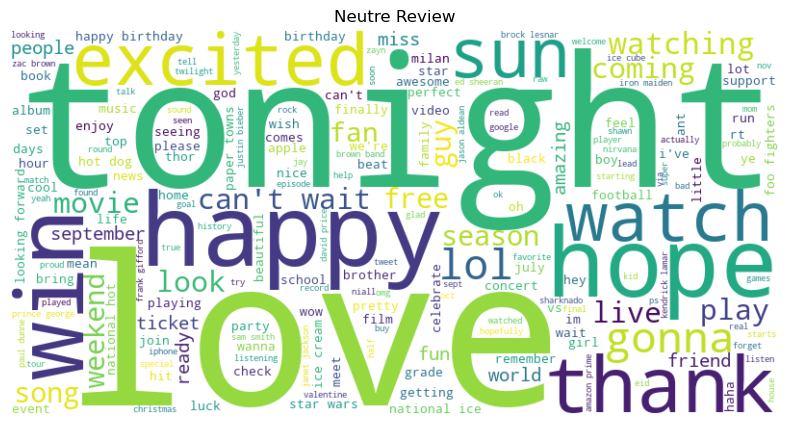

In [27]:
# Nuage de mots des tweets neutre
neutral = datas[datas['polarity']=='neutral']['text_cleaned']
neutral
generate_wordcloud(positive,'Neutre Review')

In [28]:
def get_texts_for_model(cleaned_tokens_list):
    for text_tokens in cleaned_tokens_list:
        yield dict([token,True] for token in text_tokens.split())

## 1.6 Stemmisation

In [29]:
stemmer = SnowballStemmer('english')

In [30]:
datas.text_cleaned = datas.text_cleaned.apply(lambda message: ' '.join([stemmer.stem(mot) for mot in message.split(' ')]))

In [31]:
datas.text_cleaned

0                                       match getin plus busi awar debat gulp debat
1                                                              england flake season
2                   francesco con worst qb definit toni romo like share ball includ
3        thailand washington presid barack obama vow visit storm ravag jersey shore
4                        hear toni romo dress halloween giant quaterback caus throw
                                            ...                                    
49462                                       racalto sk ok punt metlif task hope hes
49463                                                  metlif annoy didnt ruin amaz
49464                                                  giant niner fan wanna metlif
49465                                                ticket colombia vs peru metlif
49466                                        mendez told he'd drive metlif reaction
Name: text_cleaned, Length: 49467, dtype: object

## 1.7 Lemmatisation

In [32]:
lemmatizer = WordNetLemmatizer()
datas.text_cleaned = datas.text_cleaned.apply(lambda message: ' '.join([lemmatizer.lemmatize(mot) for mot in message.split(' ')]))

In [33]:
datas.text_cleaned

0                                       match getin plus busi awar debat gulp debat
1                                                              england flake season
2                   francesco con worst qb definit toni romo like share ball includ
3        thailand washington presid barack obama vow visit storm ravag jersey shore
4                        hear toni romo dress halloween giant quaterback caus throw
                                            ...                                    
49462                                        racalto sk ok punt metlif task hope he
49463                                                  metlif annoy didnt ruin amaz
49464                                                  giant niner fan wanna metlif
49465                                                 ticket colombia v peru metlif
49466                                        mendez told he'd drive metlif reaction
Name: text_cleaned, Length: 49467, dtype: object

In [34]:
df = datas

In [35]:
# On sauvegarde le dataset
df.to_csv('datas/dataset_cleaned.csv', index = False)

# 2 Entrainement du modele

### 2.1  Vectorisation

In [36]:
df = pd.read_csv('datas/dataset_cleaned.csv')

In [37]:
df.text_cleaned.fillna(" ", inplace = True)

In [38]:
df.isna().sum()

tweet_id        0
polarity        0
text            0
text_cleaned    0
dtype: int64

In [39]:
df = df.replace({'neutral':0,'positive':1,'negative':2})

In [40]:
# Decoupe des donnees
X,y = df.text_cleaned,df.polarity

In [41]:
X.shape

(49467,)

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)

In [43]:
X_train

9073                                                      rampag dm abl suit
30837                                drive dunkin week regular doughnut girl
21858                                     tgif el rememb movi s, thank god '
2913                                         realiz ukiss hyung follow kevin
36466                               legend ed sheeran love till we'r seventi
                                        ...                                 
39248            curti inde, ky davi despit amend muslim truck driver seeurl
26745                                       who zac brown band aug tri decid
47123                 rowl wrote final chapter harri potter book book releas
16146          utah ballet west take bow scott pierc write televis salt lake
2725     harveyisher final play come friday, smart araneta coliseum air live
Name: text_cleaned, Length: 39573, dtype: object

In [95]:
# Vecotirisation de X_train et X_test
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### 2.2 Quelques fonctions utiles

In [52]:
def matrice_de_confusion(y_test,pred):
    
    cmat = confusion_matrix(y_test, pred)
    plt.figure(figsize = (6, 6)) 
    sns.heatmap(cmat, annot = True,fmt="d", xticklabels=['0', '1','2'], yticklabels=['Neutre', 'Positif','Negatif'],);

In [53]:
def visualisation_resultats(model_name, model, x_train, y_train):
    
    # Calcul de la courbe d'apprentissage via la fonction learning_curve
    N, train_score, val_score = learning_curve(model, x_train, y_train, train_sizes=np.linspace(0.2, 1, 20))
    
    # Affichage du graphique
    plt.figure(figsize=(5,4))
    plt.plot(N, train_score.mean(axis=1), label="train")
    plt.plot(N, val_score.mean(axis=1), label="validation")
    plt.xlabel("train_sizes")
    plt.ylabel("Score (%)")
    plt.title("Visualisation des courbes d'apprentissage du Modèle " + model_name)
    plt.ylim(0,1)
    plt.legend()
    
    return

In [54]:
def mesure_performance_test(model_name,model, x_test, y_test):
    
    # Affichage de la courbe y_test / y_pred
    y_pred = model.predict(x_test)
    
    dict_resultats_test = {
        'Model': model_name,
        'f1_score': f1_score(y_test, y_pred, average='micro'),
        'RMSE_score': mean_squared_error(y_test, y_pred, squared=False),
        'Recall_score': recall_score(y_test, y_pred,average='micro'),
        'Precision_score': precision_score(y_test, y_pred,average='micro'),
         }
    
    
    df_dico_test = pd.DataFrame(dict_resultats_test, index=[0])
    
    # Affichage de la courbe y_test / y_pred
    maximum = max(max(y_test), max(y_pred)) * 1.1
    minimum = min(min(y_test), min(y_pred)) * 0.9

    sns.kdeplot(y_test, label="Valeur réelles")
    sns.kdeplot(y_pred, label="Prédictions")
    plt.xlabel("Valeurs")
    plt.ylabel("Densité de distrib.")
    plt.xlim(minimum, maximum)
    plt.legend()
    plt.title("Distribution des prédictions VS valeurs réelles")
    plt.show()
    
    return df_dico_test

### 2.3 Multimodal Naive Bayes

In [55]:
%%time
model_bayes = MultinomialNB()
model_bayes.fit(X_train_vectorized, y_train)

CPU times: total: 46.9 ms
Wall time: 53.1 ms


MultinomialNB()

In [56]:
%%time
pred1 = model_bayes.predict(X_test_vectorized)

CPU times: total: 15.6 ms
Wall time: 15 ms


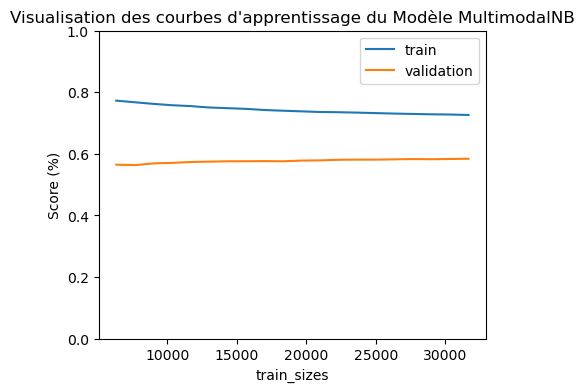

In [57]:
# Courbe d'apprentissage
visualisation_resultats('MultimodalNB', model_bayes,X_train_vectorized,y_train)

In [58]:
# 0 - Neutre
# 1 - Positif
# 2 - Negatif
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       0.54      0.77      0.63      4346
           1       0.64      0.59      0.62      4007
           2       0.69      0.02      0.04      1541

    accuracy                           0.58      9894
   macro avg       0.62      0.46      0.43      9894
weighted avg       0.60      0.58      0.53      9894



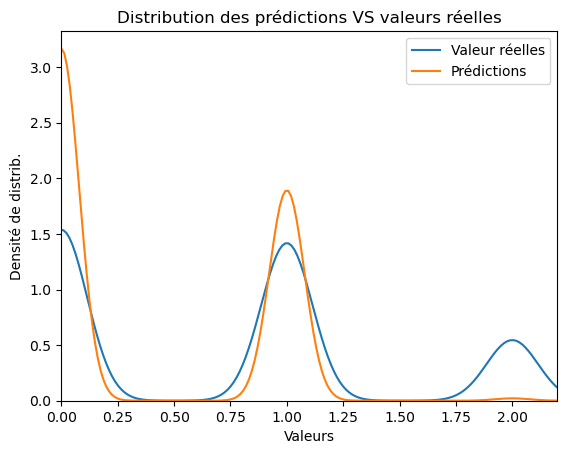

In [117]:
# Courbe des predictions
scores = mesure_performance_test('MutimodalNB', model_bayes,X_test_vectorized,y_test)

In [118]:
scores

,Model,f1_score,RMSE_score,Recall_score,Precision_score
0,MutimodalNB,0.57833,0.888008,0.57833,0.57833


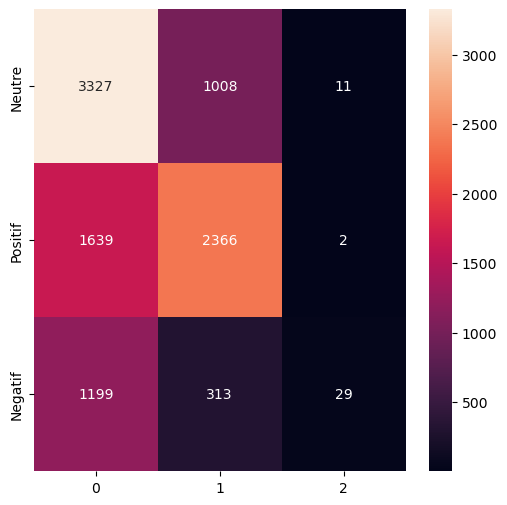

In [60]:
# Matrice de confusion
matrice_de_confusion(y_test, pred1)

### 2.5 Logistic Regression

In [62]:
%%time
model_lr = LogisticRegression(solver='liblinear', penalty ='l2' , C = 1.0)
model_lr.fit(X_train_vectorized, y_train)

CPU times: total: 1.14 s
Wall time: 757 ms


LogisticRegression(solver='liblinear')

In [63]:
%%time
pred2 = model_lr.predict(X_test_vectorized)

CPU times: total: 0 ns
Wall time: 4.53 ms


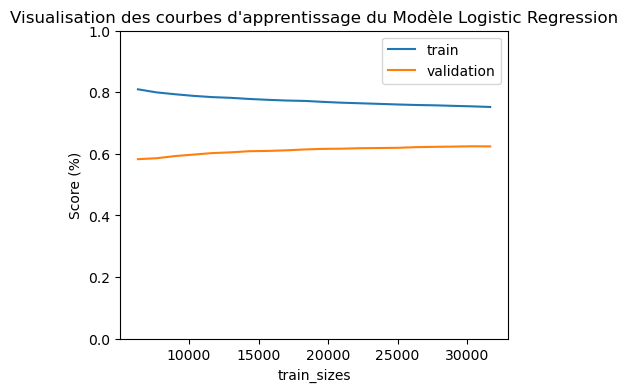

In [64]:
# Courbe d'apprentissage
visualisation_resultats('Logistic Regression', model_lr,X_train_vectorized,y_train)

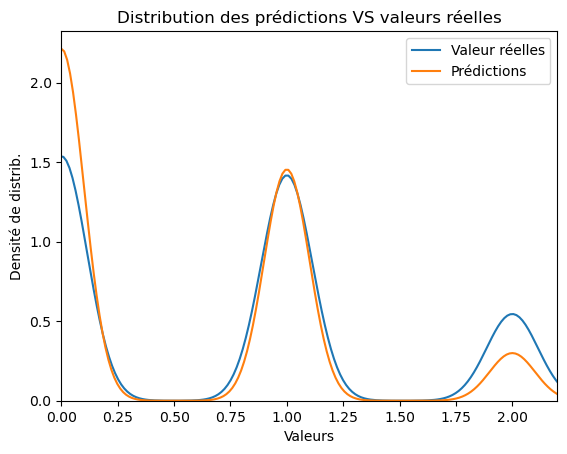

In [114]:
# Scores
scores = mesure_performance_test('Logistic Regression', model_lr,X_test_vectorized,y_test)

In [115]:
scores

,Model,f1_score,RMSE_score,Recall_score,Precision_score
0,Logistic Regression,0.627653,0.819894,0.627653,0.627653


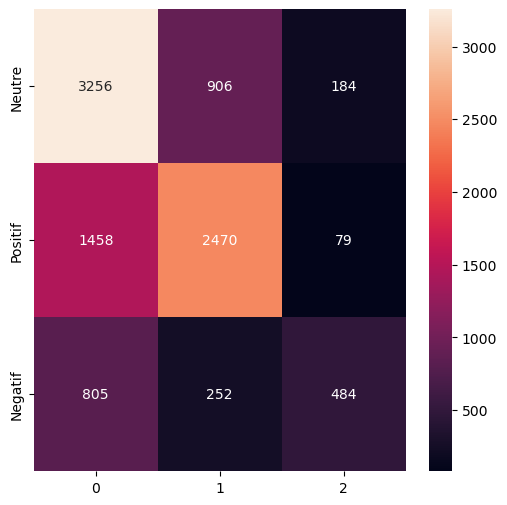

In [67]:
# Matrice de confusion
matrice_de_confusion(y_test, pred2)

In [68]:
print('Accuracy: ', accuracy_score(y_test, pred2) * 100)

Accuracy:  62.765312310491204


### 2.7 Naive Bayes Classifier

In [259]:
positive_list =  positive.tolist()
negative_list =  negative.tolist()
neutral_list =  neutral.tolist()

In [260]:
positive_list

['tim tebow availible wow jerry heck waiting',
 'mariakaykay aga tayo ah ces love',
 'lunch lil spot cotton bowl pretty',
 'snc halloween pr pumped packers vs caresn snc cheerpracticeonhalloween',
 'louis inspired outfit zayn inspired outfit harry',
 'love banner unfurled united read chelsea standing racism',
 'repost chris bosh ugly gorgeous wife adorbs baby happy oneurl',
 'gary ablett wins aflpa mvp career started speech yeah',
 'lana del rey hammersmith apollo badly tickets',
 'abc jaketapper country music awards little credibility tcot',
 'philippines phone london excited littlethngs niallofficial',
 'tonight dr terrie hale scheckelhoff formally installed head school welcome saints family tscheckelhoff',
 'solz true niners fan brought interview season',
 'patriots extend lead cruise lead pats pulpit patriots extended lead',
 'kevorf yeah suarez score near played pretty half bad probably et',
 'pretty little liars shit wait til wanna innocent allison dying',
 'monicagonzo texas bay

In [226]:
words = positive_list+negative_list+neutral_list
vocab = []
for word in tqdm(words):
    vocab = vocab + word.split()

100%|████████████████████████████████████████████████████████████████████████████| 49467/49467 [10:57<00:00, 75.26it/s]


In [240]:
# open file in write mode
with open('words.txt', 'w') as fp:
    for item in vocab:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [241]:
vocab

['tim',
 'tebow',
 'availible',
 'wow',
 'jerry',
 'heck',
 'waiting',
 'mariakaykay',
 'aga',
 'tayo',
 'ah',
 'ces',
 'love',
 'lunch',
 'lil',
 'spot',
 'cotton',
 'bowl',
 'pretty',
 'snc',
 'halloween',
 'pr',
 'pumped',
 'packers',
 'vs',
 'caresn',
 'snc',
 'cheerpracticeonhalloween',
 'louis',
 'inspired',
 'outfit',
 'zayn',
 'inspired',
 'outfit',
 'harry',
 'love',
 'banner',
 'unfurled',
 'united',
 'read',
 'chelsea',
 'standing',
 'racism',
 'repost',
 'chris',
 'bosh',
 'ugly',
 'gorgeous',
 'wife',
 'adorbs',
 'baby',
 'happy',
 'oneurl',
 'gary',
 'ablett',
 'wins',
 'aflpa',
 'mvp',
 'career',
 'started',
 'speech',
 'yeah',
 'lana',
 'del',
 'rey',
 'hammersmith',
 'apollo',
 'badly',
 'tickets',
 'abc',
 'jaketapper',
 'country',
 'music',
 'awards',
 'little',
 'credibility',
 'tcot',
 'philippines',
 'phone',
 'london',
 'excited',
 'littlethngs',
 'niallofficial',
 'tonight',
 'dr',
 'terrie',
 'hale',
 'scheckelhoff',
 'formally',
 'installed',
 'head',
 'school

In [242]:
positive_tokens_list = get_texts_for_model(positive_list)
negative_tokens_list = get_texts_for_model(negative_list)
neutral_tokens_list = get_texts_for_model(neutral_list)

In [243]:
positive_dataset = [(review_dict,'positive') for review_dict in positive_tokens_list]
negative_dataset = [(review_dict,'negative') for review_dict in negative_tokens_list]
neutral_dataset = [(review_dict,'neutral') for review_dict in neutral_tokens_list]

In [244]:
dataset = positive_dataset + negative_dataset+ neutral_dataset
random.shuffle(dataset)

In [245]:
train_data, test_data = train_test_split(dataset,test_size=0.3,random_state=42)
# test_data, val_data = train_test_split(test_data,test_size=0.5,random_state=42)

In [246]:
clf = nltk.NaiveBayesClassifier.train(train_data)

In [247]:
train_accuracy = round(classify.accuracy(clf,train_data),2)*100
test_accuracy = round(classify.accuracy(clf,test_data),2)*100

In [248]:
print("Train accuracy is ", train_accuracy)
print("Test accuracy is ", test_accuracy)

Train accuracy is  81.0
Test accuracy is  56.99999999999999


In [249]:
print(clf.show_most_informative_features(10))

Most Informative Features
                   worst = True           negati : positi =     49.1 : 1.0
                 amazing = True           positi : negati =     48.7 : 1.0
                   yakub = True           negati : positi =     45.8 : 1.0
                  fucked = True           negati : positi =     42.9 : 1.0
                 excited = True           positi : neutra =     40.4 : 1.0
                 erdogan = True           negati : positi =     34.8 : 1.0
            disappointed = True           negati : positi =     34.5 : 1.0
               terrorist = True           negati : positi =     32.8 : 1.0
                bullshit = True           negati : positi =     31.1 : 1.0
                  threat = True           negati : positi =     29.4 : 1.0
None


In [254]:
test_sentence = "Very Good Service offered by Team."

In [255]:
test_sent_features = {word: (word in word_tokenize(test_sentence.lower())) for word in vocab}
test_sent_features

{'tim': False,
 'tebow': False,
 'availible': False,
 'wow': False,
 'jerry': False,
 'heck': False,
 'waiting': False,
 'mariakaykay': False,
 'aga': False,
 'tayo': False,
 'ah': False,
 'ces': False,
 'love': False,
 'lunch': False,
 'lil': False,
 'spot': False,
 'cotton': False,
 'bowl': False,
 'pretty': False,
 'snc': False,
 'halloween': False,
 'pr': False,
 'pumped': False,
 'packers': False,
 'vs': False,
 'caresn': False,
 'cheerpracticeonhalloween': False,
 'louis': False,
 'inspired': False,
 'outfit': False,
 'zayn': False,
 'harry': False,
 'banner': False,
 'unfurled': False,
 'united': False,
 'read': False,
 'chelsea': False,
 'standing': False,
 'racism': False,
 'repost': False,
 'chris': False,
 'bosh': False,
 'ugly': False,
 'gorgeous': False,
 'wife': False,
 'adorbs': False,
 'baby': False,
 'happy': False,
 'oneurl': False,
 'gary': False,
 'ablett': False,
 'wins': False,
 'aflpa': False,
 'mvp': False,
 'career': False,
 'started': False,
 'speech': False,


In [256]:
clf.classify(test_sent_features)

'negative'

# 3. Optimisation du model

In [69]:
# Pipeline
pipeline = Pipeline([('tfidf',TfidfVectorizer()),('algorithm',LogisticRegression())])

In [81]:
param_grid ={
    'algorithm__C': np.asarray([1,2,3,4,5,6,7,8,9,10]),
    'algorithm__max_iter': [20, 50, 100, 200, 500, 1000],                      
    'algorithm__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  
    'algorithm__class_weight': ['balanced'] 
}

grid_search  = GridSearchCV(pipeline, param_grid, cv = 2)
grid_search.fit(X_train,y_train)


C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:35

C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.

C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:35

C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nouna\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:35

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('algorithm', LogisticRegression())]),
             param_grid={'algorithm__C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'algorithm__class_weight': ['balanced'],
                         'algorithm__max_iter': [20, 50, 100, 200, 500, 1000],
                         'algorithm__solver': ['newton-cg', 'lbfgs',
                                               'liblinear', 'sag', 'saga']})

In [82]:
print(grid_search.best_params_)

{'algorithm__C': 1, 'algorithm__class_weight': 'balanced', 'algorithm__max_iter': 20, 'algorithm__solver': 'liblinear'}


In [83]:
print(grid_search.best_estimator_)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('algorithm',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=20,
                                    solver='liblinear'))])


In [84]:
# training
best_model = grid_search.best_estimator_

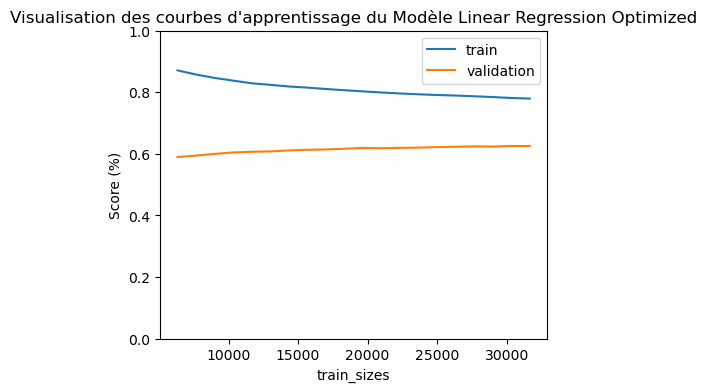

In [111]:
# Courbe d'apprentissage
visualisation_resultats('Linear Regression Optimized', best_model,X_train,y_train)

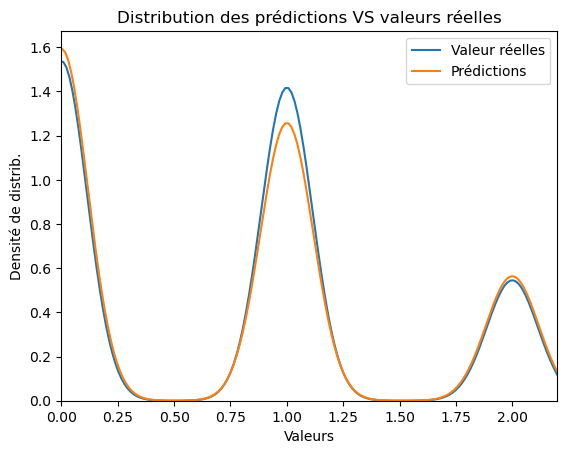

In [112]:
# Scores
scores = mesure_performance_test('Linear Regression Optimized', best_model,X_test,y_test)

In [113]:
scores

,Model,f1_score,RMSE_score,Recall_score,Precision_score
0,Linear Regression Optimized,0.625733,0.831887,0.625733,0.625733


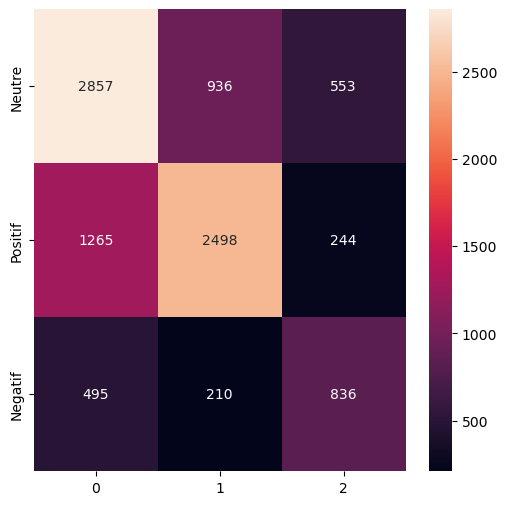

In [109]:
# Matrice de confusion
matrice_de_confusion(y_test, best_model.predict(X_test))

In [97]:
print(classification_report(y_test, best_model.predict(X_test),digits = 4))

              precision    recall  f1-score   support

           0     0.6188    0.6574    0.6375      4346
           1     0.6855    0.6234    0.6530      4007
           2     0.5119    0.5425    0.5268      1541

    accuracy                         0.6257      9894
   macro avg     0.6054    0.6078    0.6058      9894
weighted avg     0.6292    0.6257    0.6265      9894



In [98]:
def ml(message,model):
    text = text_preprocessing(message)
    # Stops words
    text = ' '.join([mot for mot in message.split() if mot not in (stop_words)])
    # Stemmatisation
    text = ' '.join([stemmer.stem(mot) for mot in message.split(' ')])
    # Lemmatisation
    text = ' '.join([lemmatizer.lemmatize(mot) for mot in message.split(' ')])
    # TfIdf Initialization
    vectorizer= TfidfVectorizer()
    # Vectorisation
    x_vect = vectorizer.transform([message])
    # Prediction
    prediction = model.predict(x_vect)
    cls = ['neutre', 'positif','negatif']
    print(">>> Vous avez etes " + str(cls[prediction[0]]))
    return 
    

In [99]:
message = "Very Good Service offered by Team."
# ml(message)

In [100]:
# save the model to disk
filename = 'model_lr.sav'
pickle.dump(best_model, open(filename, 'wb'))
vectorizer= TfidfVectorizer()
x_vect = vectorizer.fit_transform([message])

In [104]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict([message])
print(result)

[1]
